# DOY of sea ice onset

In [1]:
## import required packages
import numpy as np
import pandas as pd
import sys
import xarray as xr
import matplotlib.pyplot as plt
import s3fs
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings("ignore", module='distributed')

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45187")
client

<Client: 'tcp://127.0.0.1:45187' processes=8 threads=32, memory=123.95 GiB>

In [3]:
# open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")
HH_grid_land = HH_grid.maskC.isel(k=0).where(HH_grid.maskC.isel(k=0)==0)
HH_land_beaufort = HH_grid_land.isel(i=slice(510,750),j=slice(110,390))

In [4]:
# open sea ice dataset
ice_yrs_masked = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/SIC/SIC_masked_Beaufort.ZARR')
ice_yrs_masked = ice_yrs_masked.sic.sel(i=slice(510,750),j=slice(110,390))

In [5]:
def find_ice_onset_doy(sic, threshold=15, duration=5):
    # Convert to binary mask: 1 if SIC >= threshold, else 0
    ice_mask = sic >= threshold

    # Rolling sum over time to find 3-day periods over threshold
    ice_rolling = ice_mask.rolling(time=duration, center=False).sum()

    # First time index where the rolling sum equals duration
    condition_met = (ice_rolling >= duration)

    # Find the first time index this condition is True
    def first_true_doy(x, time_coords):
        if not np.any(x):
            return np.nan
        first_index = np.argmax(x)
        return pd.to_datetime(time_coords[first_index]).dayofyear

    # Apply over grid cells
    doy = xr.apply_ufunc(
        first_true_doy,
        condition_met,
        condition_met['time'],
        input_core_dims=[['time'], ['time']],
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )

    return doy

In [7]:
def rotate_dataarray_90ccw(da):
    """
    Rotate a 3D xarray.DataArray (time, i, j) 90 degrees counterclockwise.
    
    Parameters:
        da (xr.DataArray): Input data array with dims ('time', 'i', 'j').
        
    Returns:
        xr.DataArray: Rotated DataArray with dims ('time', 'i', 'j').
    """
    rotated = np.rot90(da,3,axes=[0,1])

    # do not retain original llc grid
    out = xr.DataArray(
        data=rotated,
        dims=('i','j'),
        name=f"{da.name}"
    )
    
    return out

In [8]:
HH_grid_land_rot = rotate_dataarray_90ccw(HH_land_beaufort)

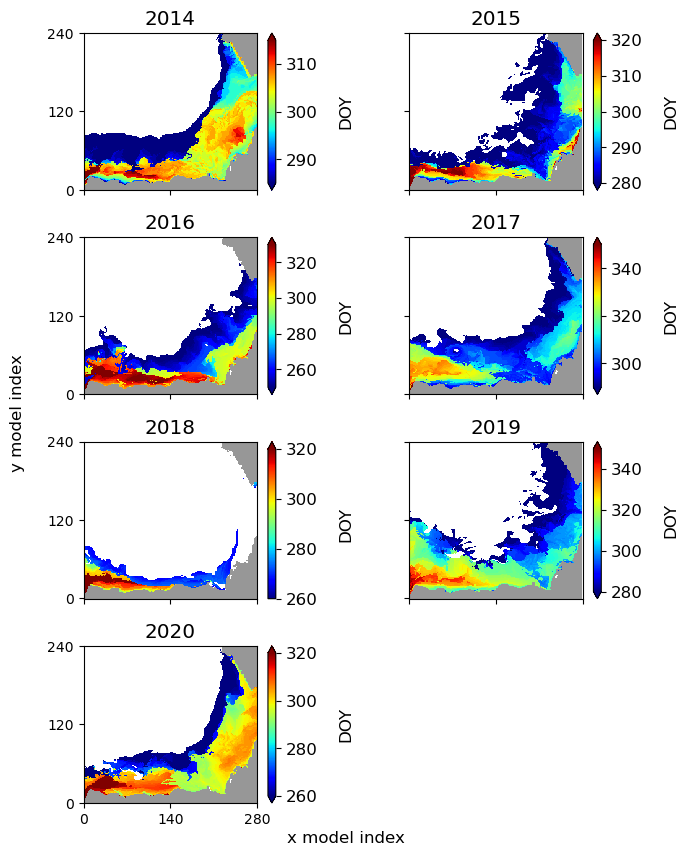

In [9]:
years = np.arange(2014, 2021)
n_years = len(years)

# 4 rows, 2 columns (1 unused)
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=[7, 10])
plt.rcParams['font.size'] = 12
axs = axs.flatten()

for i, year in enumerate(years):
    ax = axs[i]

    # Compute DOY when SIC > 15% for 3+ days
    doy_ice_onset = find_ice_onset_doy(
        ice_yrs_masked.sel(time=str(year)).chunk(dict(time=-1)),
        threshold=15, duration=3
    )

    # Rotate so Alaska is at bottom
    doy_ice_onset_rot = rotate_dataarray_90ccw(doy_ice_onset)

    # Define vmin and vmax ranges in a dictionary
    vmin_vmax_dict = {
        0: (285, 315),
        1: (280, 320),
        2: (250, 330),
        3: (290, 350),
        4: (260, 320),
        5: (280, 350),
        6: (260, 320)
    }
    
    # Use the dictionary to get the correct vmin and vmax for each plot
    vmin, vmax = vmin_vmax_dict.get(i, (None, None))
    
    pcm = doy_ice_onset_rot.plot(ax=ax, vmin=vmin, vmax=vmax, cmap='jet')

    HH_grid_land_rot.plot(ax=ax, cmap='Greys_r', add_colorbar=False)

    # Set subplot title and clean axis labels
    ax.set_title(f"{year}")
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.set_ylim(500,800)

    # Get and label the colorbar
    if pcm.colorbar is not None:
        pcm.colorbar.set_label("DOY", rotation=90, labelpad=15, fontsize=12)

axs[0].set_xticks([0,140,280])
axs[0].set_yticks([0,120,240])

# Hide unused subplot
if n_years < len(axs):
    axs[-1].axis('off')

fig.subplots_adjust(wspace=0.5, hspace=0.3)
fig.text(0.5, 0.07, 'x model index', ha='center', fontsize=12)
fig.text(0.02, 0.5, 'y model index', va='center', rotation='vertical', fontsize=12);

fig.savefig('/home/jpluser/git_repos/SASSIE_ECCO_salinity_stratification/figures/DOY_ice_onset.png',
            dpi=300, bbox_inches='tight')